In [13]:
import pandas as pd
import numpy as np
import os, sys
from models.evaluate import *
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from models.metrics import *

PATH = os.getcwd()
DIR_RES = os.path.join(os.path.join(PATH, 'results'),'final_results')
DIR_WEIGHTS = os.path.join(DIR_RES, 'aggregation_weights')
sns.set_style('whitegrid')

_____

# 0. Code to execute

In [68]:
def reorder_quantiles(df):
    df = df.sort_values(by=['Date', 'Hour', 'model', 'quantile'])
    dfp = pd.pivot_table(df, values='SpotPrice_pred', index=['model', 'Date', 'Hour', 'SpotPrice'],
                         columns='quantile')
    dfp.columns = np.sort(dfp.columns)
    dfp.iloc[:, :] = np.sort(dfp, axis=1)
    df = pd.melt(dfp.reset_index(), id_vars=['model', 'Date', 'Hour', 'SpotPrice'], var_name='quantile',
                 value_name='SpotPrice_pred')
    df = df.sort_values(by=['Date', 'Hour', 'model', 'quantile'])
    return df


def evaluate_quantile_pred_modif(df_pred, alpha, start=None, end=None, plot=False, hue='model_name', style='model_style', palette=None, **kwargs):
    ylim1 = kwargs.pop('ylim1') if 'ylim1' in kwargs else (0,100)
    ylim2 = kwargs.pop('ylim2') if 'ylim2' in kwargs else (0,50)
    
    start = df_pred.Date.min() if start is None else start
    end = df_pred.Date.max() if end is None else end
    df_quantile_scores = pd.DataFrame()

    for a in tqdm(alpha):
        assert a != 0, "Cannot compute quantile score for median prediction, Please use RMSE"
        q_up, q_down = round(100 * (a + 1) / 2, 2), round(100 * (1 - a) / 2, 2)

        for hue_val in df_pred[hue].unique():
            for style_val in df_pred[style].unique():
                df_to_score = df_pred[(df_pred[hue] == hue_val) &
                                      (df_pred[style] == style_val) &
                                      (df_pred['quantile'].isin([q_up, q_down])) &
                                      (df_pred.Date >= start) &
                                      (df_pred.Date <= end)
                                      ]
                if len(df_to_score) > 0:

                    y_true = df_to_score[df_to_score['quantile'] == q_up].SpotPrice.reset_index(drop=True)
                    y_high = df_to_score[df_to_score['quantile'] == q_up].SpotPrice_pred.reset_index(drop=True)
                    y_low = df_to_score[df_to_score['quantile'] == q_down].SpotPrice_pred.reset_index(drop=True)

                    emp_cov = empirical_coverage(y_true, y_low, y_high)
                    wr_score = wrinkler_score(y_true, y_low, y_high, alpha=a)
                    # unc_cov = unconditional_coverage(y_true, y_low, y_high, alpha=a)
                    int_width = interval_width(y_low, y_high)

                    df_quantile_scores = df_quantile_scores.append(
                        pd.DataFrame({
                            hue : df_to_score[hue].iloc[0],
                            style : df_to_score[style].iloc[0],
                            'alpha': [a],
                            'empirical_coverage': [emp_cov- a],
                            'wrinkler_score': [wr_score],
                            # 'unconditional_coverage': [unc_cov], # TODO : Fix this score
                            'interval_width': [int_width]
                        })
                    )

    if plot:
        fig, axes = plt.subplots(1, 3)
        label_name = ['$\Delta_{coverage}$', 'Winkler score', "Interval width"]
        for i, score in enumerate(['empirical_coverage', 'wrinkler_score', 'interval_width']):

            sns.lineplot(
                data=df_quantile_scores.rename(columns={'alpha': 'target_coverage'}).reset_index(),
                x='target_coverage',
                y=score,
                hue=hue,
                style=style,
                markers=True,
                ax=axes[i],
                palette=palette,
                **kwargs)
            axes[i].set_xlabel('Target coverage')
            axes[i].set_ylabel(label_name[i])

            if i < 2:
                axes[i].legend([])
            
            else:
                axes[i].legend(loc='upper right', bbox_to_anchor=(1.5, 1))

            if score == 'empirical_coverage':
                axes[i].plot([0.5, 1], [0, 0], c='k')

        #axes[0].set_ylim((-0.1, 0.1))
        axes[1].set_ylim(ylim1)
        axes[2].set_ylim(ylim2)
        fig.set_size_inches((30, 10))

    return df_quantile_scores


def evaluate_quantile_pred_2(df_pred, alpha, start=None, end=None, plot=False, hue='model_name', style='model_style', palette=None, **kwargs):
    #ylim1 = kwargs.pop('ylim1') if 'ylim1' in kwargs else (0,100)
    ylim2 = kwargs.pop('ylim2') if 'ylim2' in kwargs else (0,50)
    
    start = df_pred.Date.min() if start is None else start
    end = df_pred.Date.max() if end is None else end
    df_quantile_scores = pd.DataFrame()

    for a in tqdm(alpha):
        assert a != 0, "Cannot compute quantile score for median prediction, Please use RMSE"
        q_up, q_down = round(100 * (a + 1) / 2, 2), round(100 * (1 - a) / 2, 2)

        for hue_val in df_pred[hue].unique():
            for style_val in df_pred[style].unique():
                df_to_score = df_pred[(df_pred[hue] == hue_val) &
                                      (df_pred[style] == style_val) &
                                      (df_pred['quantile'].isin([q_up, q_down])) &
                                      (df_pred.Date >= start) &
                                      (df_pred.Date <= end)
                                      ]
                if len(df_to_score) > 0:

                    y_true = df_to_score[df_to_score['quantile'] == q_up].SpotPrice.reset_index(drop=True)
                    y_high = df_to_score[df_to_score['quantile'] == q_up].SpotPrice_pred.reset_index(drop=True)
                    y_low = df_to_score[df_to_score['quantile'] == q_down].SpotPrice_pred.reset_index(drop=True)

                    emp_cov = empirical_coverage(y_true, y_low, y_high)
                    #wr_score = wrinkler_score(y_true, y_low, y_high, alpha=a)
                    # unc_cov = unconditional_coverage(y_true, y_low, y_high, alpha=a)
                    int_width = interval_width(y_low, y_high)

                    df_quantile_scores = df_quantile_scores.append(
                        pd.DataFrame({
                            hue : df_to_score[hue].iloc[0],
                            style : df_to_score[style].iloc[0],
                            'alpha': [a],
                            'empirical_coverage': [emp_cov- a],
                            #'wrinkler_score': [wr_score],
                            # 'unconditional_coverage': [unc_cov], # TODO : Fix this score
                            'interval_width': [int_width]
                        })
                    )

    if plot:
        label_name = ['$\Delta_{coverage}$', "Interval width"]
        fig, axes = plt.subplots(1, 2)
        for i, score in enumerate(['empirical_coverage', 'interval_width']):

            sns.lineplot(
                data=df_quantile_scores.rename(columns={'alpha': 'target_coverage'}).reset_index(),
                x='target_coverage',
                y=score,
                hue=hue,
                style=style,
                markers=True,
                ax=axes[i],
                palette=palette,
                **kwargs)
            axes[i].set_xlabel('Target coverage')
            axes[i].set_ylabel(label_name[i])

            if i < 1:
                axes[i].legend([])
            
            else:
                axes[i].legend(loc='upper right', bbox_to_anchor=(1.5, 1))

            if score == 'empirical_coverage':
                axes[i].plot([0.5, 1], [0, 0], c='k')

        #axes[0].set_ylim((-0.1, 0.1))
        axes[1].set_ylim(ylim2)
        fig.set_size_inches((30, 10))

    return df_quantile_scores

_____

# I. Graphs of weights aggregation

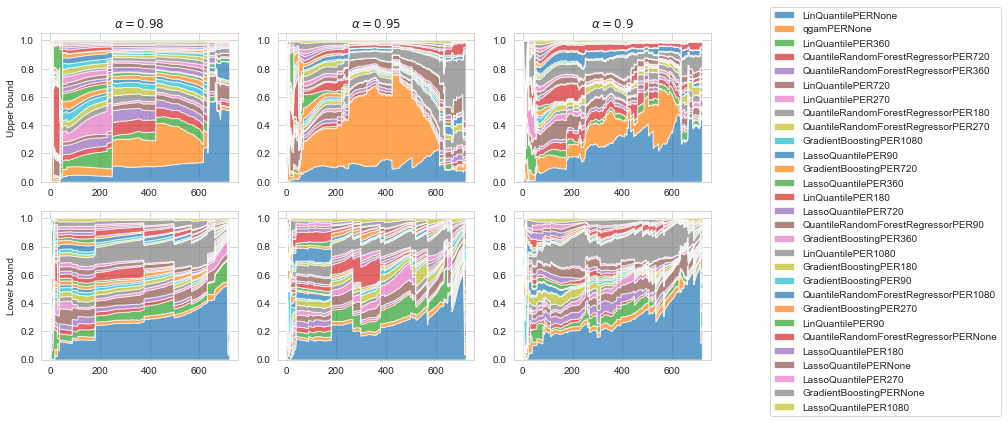

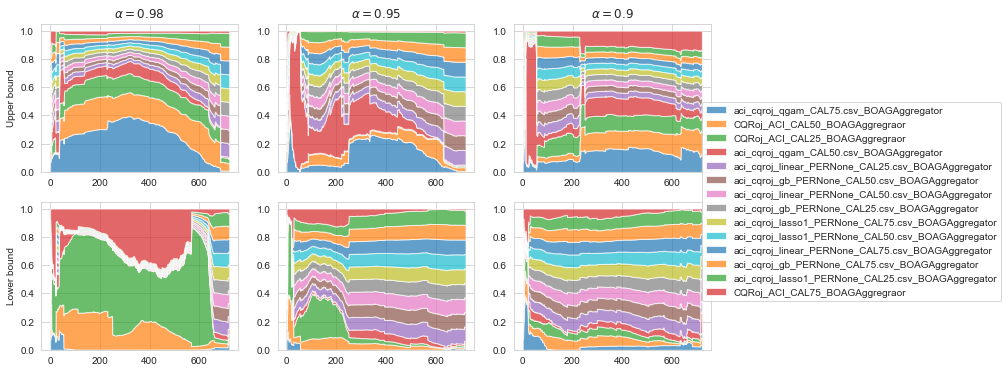

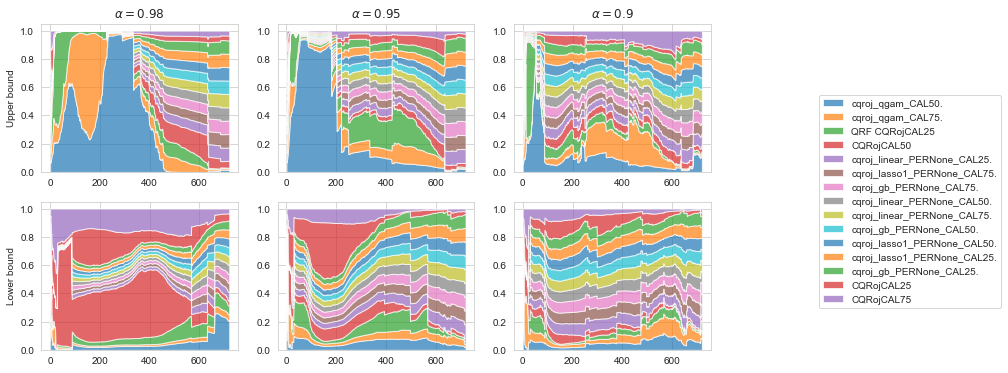

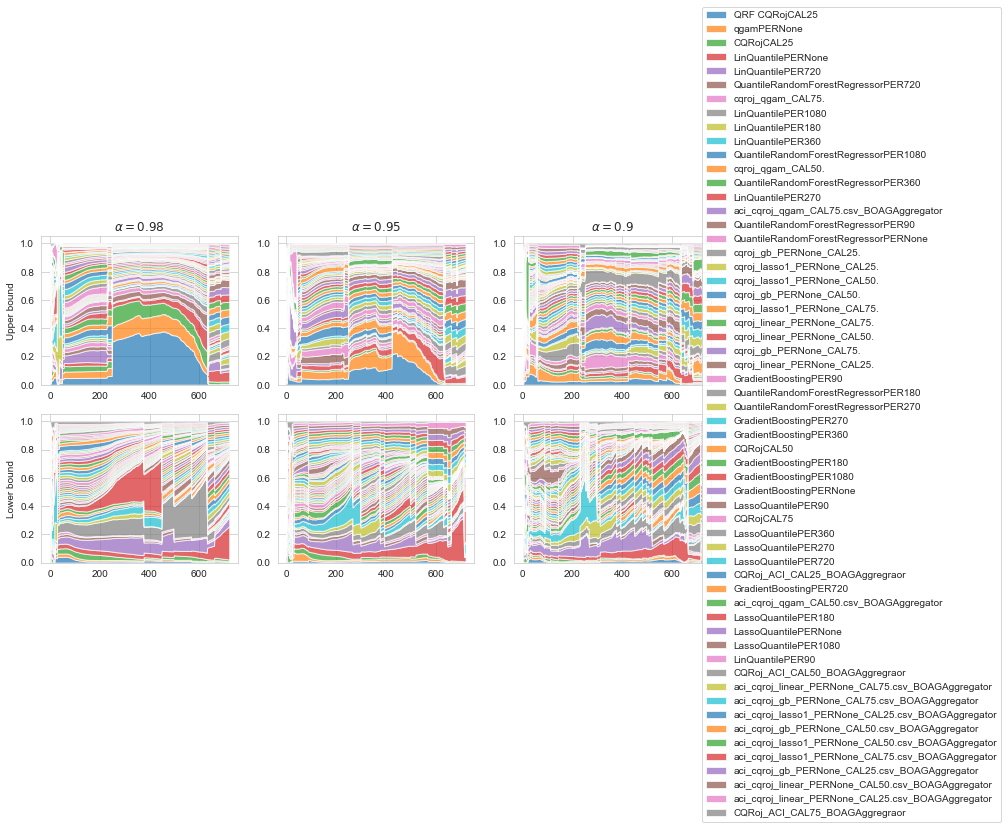

In [14]:

for i, agg_model in enumerate(['merged_no_cqr', 'merged_agaci', 'merged_cqr', 'merged_all']):
    fig, axes = plt.subplots(2, 3)
    fig.set_size_inches(12, 6)
    for j, alpha in enumerate([0.98, 0.95, 0.9]):
        q_low, q_up = np.round(100*(1- alpha)/2, 2), np.round(100*(1+alpha)/2, 2)
        if q_low % 1 ==0:
            q_low = int(q_low)
            q_up = int(q_up)
        
        df_low = pd.read_csv(os.path.join(DIR_WEIGHTS, f'{agg_model}_hour_18_q_{q_low}_graph.csv')).drop(columns = 'Unnamed: 0')
        df_up = pd.read_csv(os.path.join(DIR_WEIGHTS, f'{agg_model}_hour_18_q_{q_up}_graph.csv')).drop(columns = 'Unnamed: 0')
        
        if j == 0:
            COLS = list(df_up.mean().sort_values(ascending=False).index)
        
        
        
        axes[1, j].stackplot(df_low.index,
                         [df_low[col] for col in COLS],
                         labels=COLS,
                         alpha=0.7,
                         #colors = [PALETTE_DIC[feature] for feature in dfg_.feature_cat.unique()]
                         )
        axes[0, j].stackplot(df_up.index,
                         [df_up[col] for col in COLS],
                         labels=COLS,
                         alpha=0.7
                         )
        axes[0, j].set_title(f'$\\alpha = {alpha}$')
    
    axes[0, 0].set_ylabel(f'Upper bound')
    axes[1, 0].set_ylabel(f'Lower bound')
    plt.legend(loc='center right', bbox_to_anchor=(2.5, 1))
    plt.show()
    

____

## II. Results of aggregation

In [44]:
filenames = ['merged_agaci_opera_agg.csv',
             'merged_cqr_opera_agg.csv',
             'merged_no_cqr_opera_agg.csv',
             'merged_all_opera_agg.csv',
            ]
df_tot = pd.DataFrame()

for filename in filenames:
    print(filename)
    df = pd.read_csv(os.path.join(DIR_AGG_R, filename))
    df = df[df.model.str.contains('BOAGAggregator')]
    df['model'] = filename[:-4]
    
    prices = pd.read_csv(os.path.join(os.path.join(DIR_RES, 'prices.csv')))
    df = pd.merge(df, prices, on = ['Hour', 'Date'], how='left')
    if len(df_tot) > 0:
        df = df[~(df.model.isin(df_tot.model.unique()))]
    df_tot = df_tot.append(df)

df_tot = df_tot[~(df_tot['quantile']==50)]
df_tot = reorder_quantiles(df_tot)
df_tot['model_type'] = df_tot['model']
df_tot.reset_index(inplace=True, drop=True)
df = df_tot.copy()

merged_agaci_opera_agg.csv
merged_cqr_opera_agg.csv
merged_no_cqr_opera_agg.csv
merged_all_opera_agg.csv


In [45]:
df_crps = pd.DataFrame()

for i, model in enumerate(df.model.unique()):
    print(f'Computing {i}-th model ({model}) out of {df.model.nunique()}.')
    dfm = df[df.model == model]
    dfp = pd.pivot_table(dfm,
               values=['SpotPrice_pred'],
               index = ["Date", 'Hour', 'model', 'model_type', 'SpotPrice'],
               columns = ['quantile']
              ).reset_index()
    
    y_true = dfp.SpotPrice.to_numpy()
    quantile_forecast = dfp.SpotPrice_pred.to_numpy()
    tab_quantile = np.array([0] + list(dfp.SpotPrice_pred.columns))
    
    # Add the zero-th quantile
    quantile_forecast = np.hstack([np.repeat(-500, len(y_true)).reshape(-1, 1),  quantile_forecast]).T
    
    df_temp = pd.DataFrame()
    df_temp["model"] = [model]
    df_temp["model_type"] = [dfm.model_type.unique()[0]]
    df_temp['crps_score'] = [mean_crps(y_true, quantile_forecast, tab_quantile/100)]
    print('CRPS : ', mean_crps(y_true, quantile_forecast, tab_quantile/100))
    df_crps = df_crps.append(df_temp)
    
    
    
    
    
    

Computing 0-th model (merged_agaci_opera_agg) out of 4.
CRPS :  2.8817138738811376
Computing 1-th model (merged_all_opera_agg) out of 4.
CRPS :  2.8730492290974308
Computing 2-th model (merged_cqr_opera_agg) out of 4.
CRPS :  2.818513056064155
Computing 3-th model (merged_no_cqr_opera_agg) out of 4.
CRPS :  2.82888452104113


----

## II.1 - Aggregation efficiency

100%|█████████████████████████████████████████████| 8/8 [00:15<00:00,  1.97s/it]


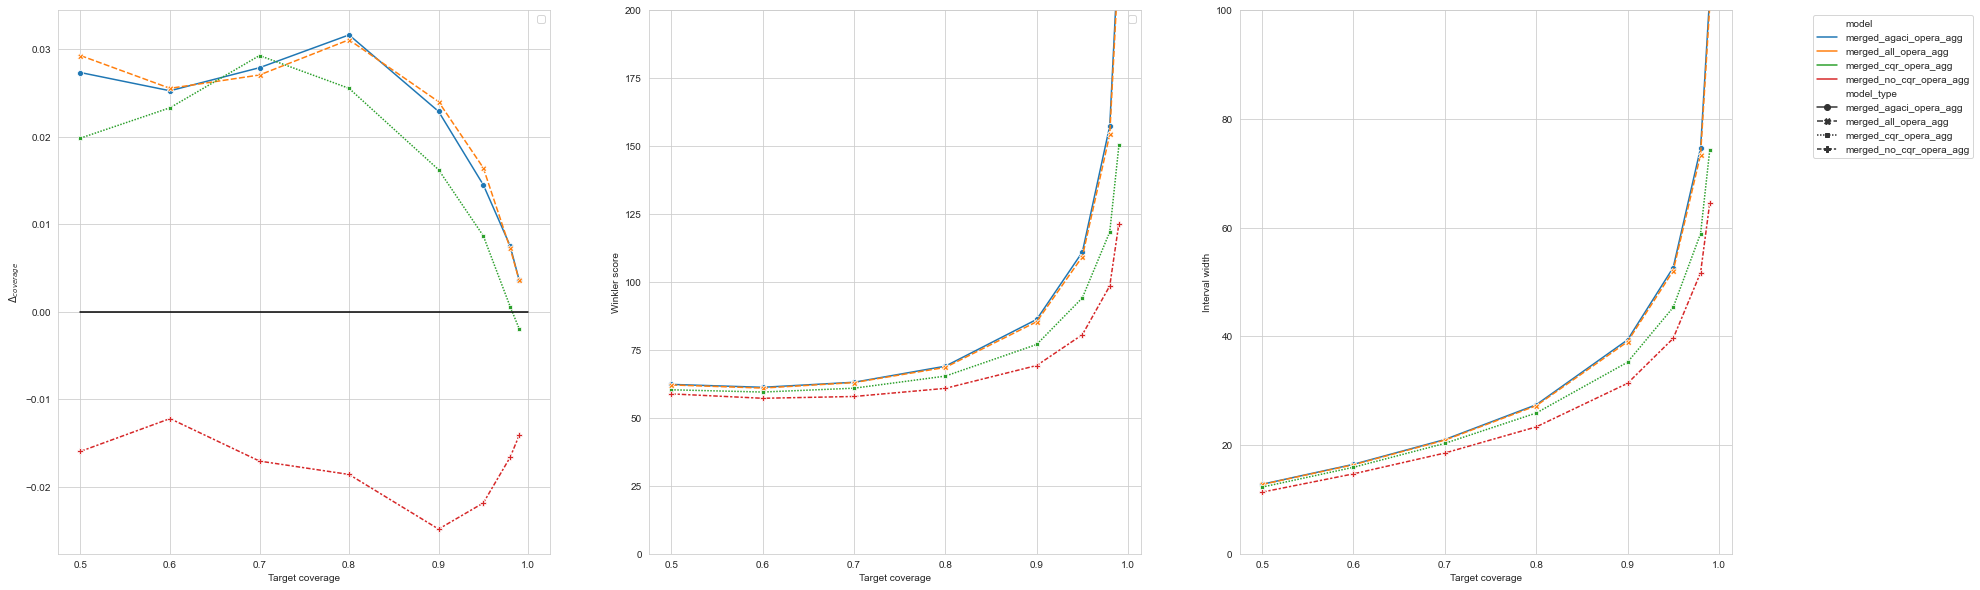

In [69]:
df.reset_index(drop=True, inplace=True)
df_ = evaluate_quantile_pred_modif(df,
                                  alpha = np.array([50, 60, 70, 80, 90, 95, 98, 99]) / 100,
                                  start = '2020-01-11',
                                  end='2021-12-31',
                                  hue='model',
                                  style='model_type',
                                  #palette=dic_colors,
                                  ylim1 = (0, 200),
                                  ylim2 = (0, 100),
                                  plot=True)

## II.1b - Coverage on two different time periods


100%|█████████████████████████████████████████████| 8/8 [00:14<00:00,  1.76s/it]


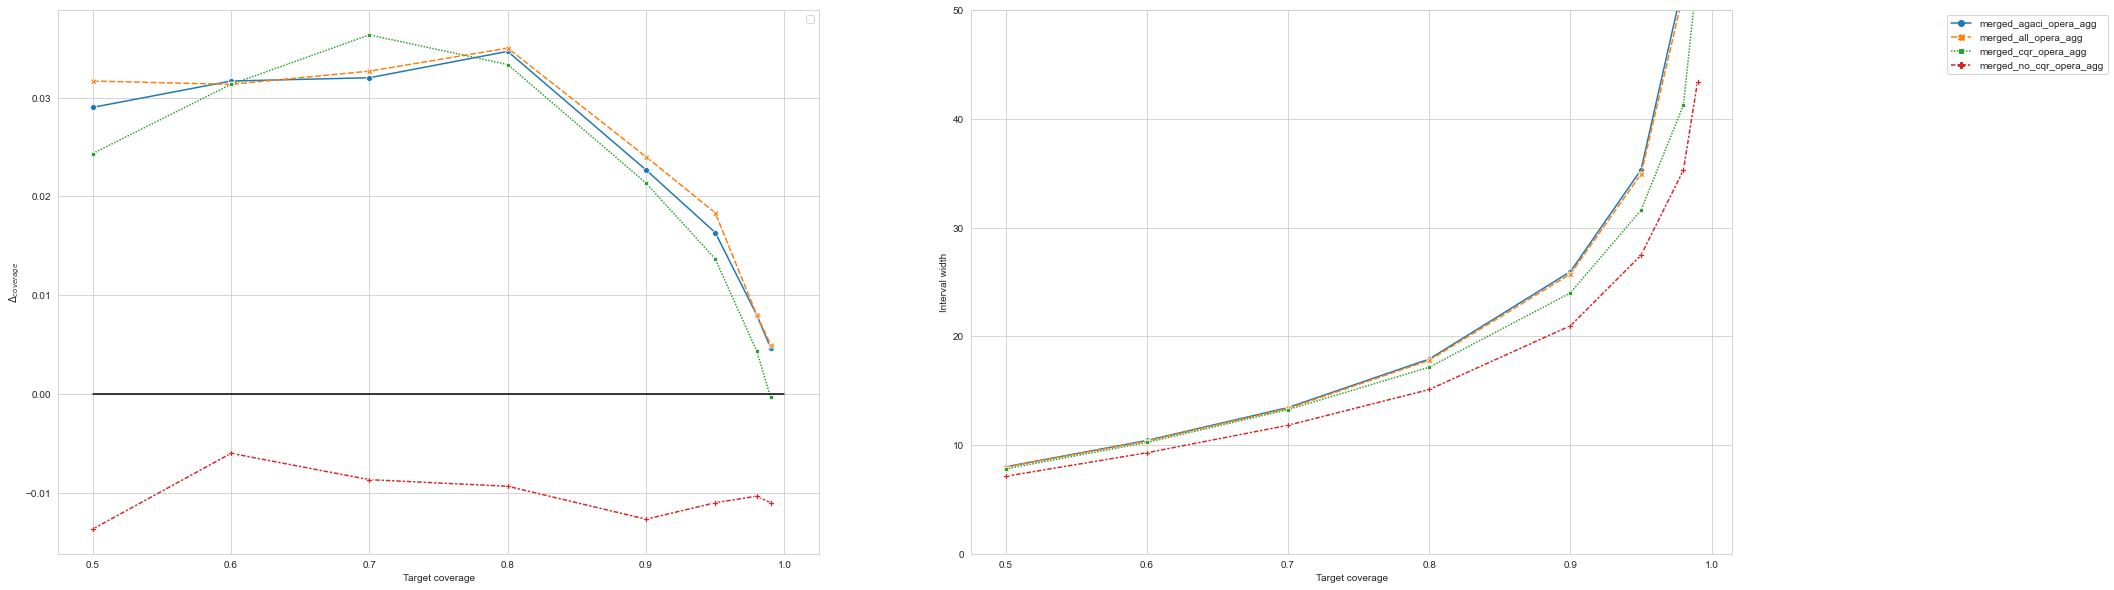

In [70]:
# Before 01/09/2021
df_ = evaluate_quantile_pred_2(df.rename(columns = {'Models in' : 'Aggregated models', 'model_type' : 'Model type'}),
                                  alpha = np.array([50, 60, 70, 80, 90, 95, 98, 99]) / 100,
                                  start = '2020-01-11',
                                  end='2021-09-01',
                                  hue='Model type',
                                  #hue='Aggregated models',
                                  style='Model type',
                                  #palette=dic_colors.values(),
                                  plot=True)

100%|█████████████████████████████████████████████| 8/8 [00:15<00:00,  1.94s/it]


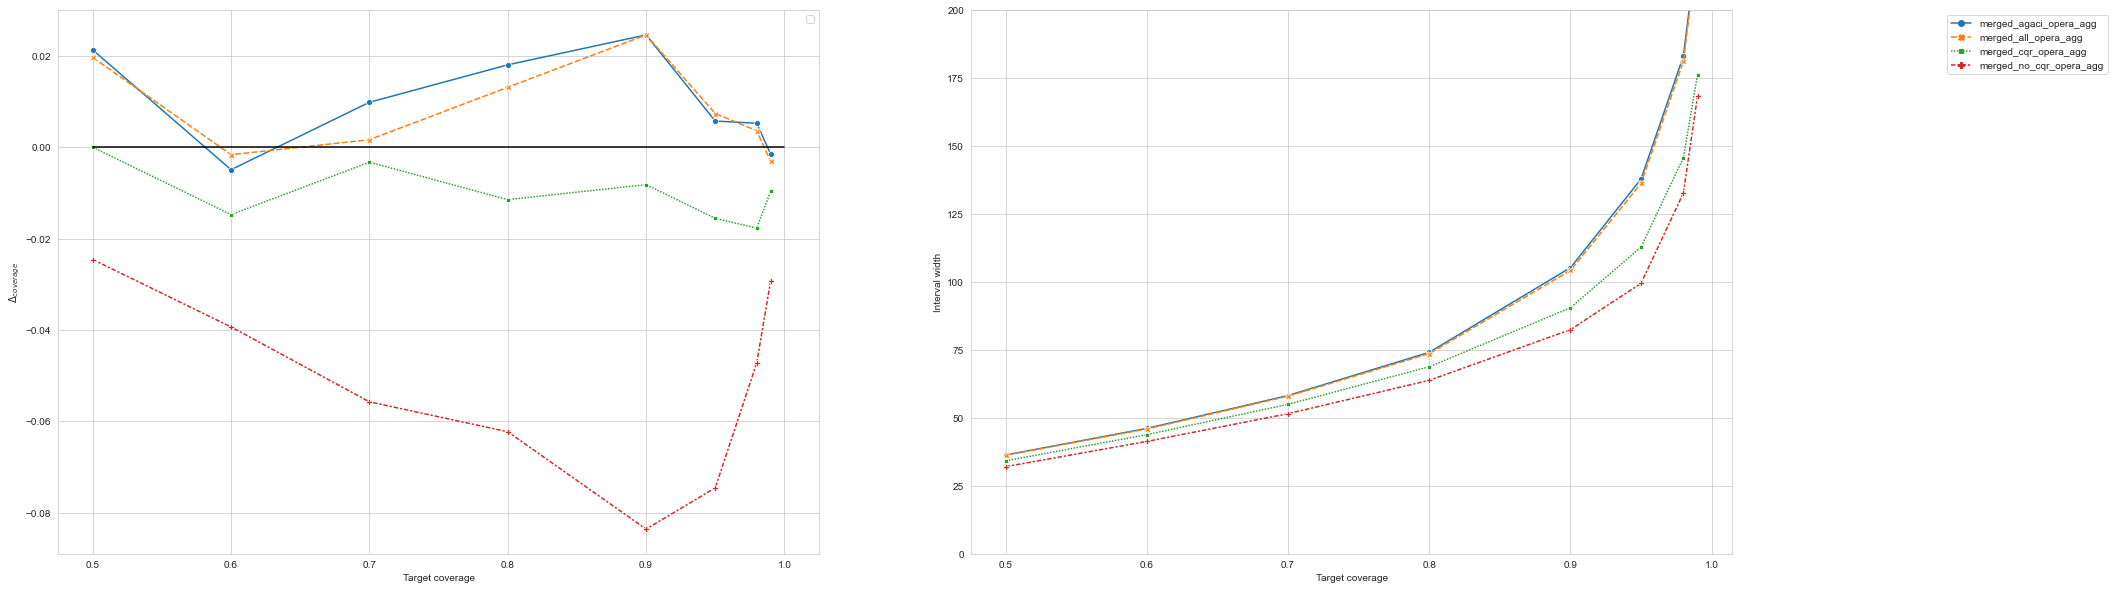

In [72]:
# After 01/09/2021
df_ = evaluate_quantile_pred_2(df.rename(columns = {'Models in' : 'Aggregated models', 'model_type' : 'Model type'}),
                                  alpha = np.array([50, 60, 70, 80, 90, 95, 98, 99]) / 100,
                                  start = '2021-09-01',
                                  end='2021-12-31',
                                  hue='Model type',
                                  #hue='Aggregated models',
                                  style='Model type',
                                  #palette=dic_colors.values(),
                                  ylim2=(0, 200),
                                  plot=True)

## II.2 - CRPS changing over time

In [51]:
df['Models in'] = 'All'
df['Time'] = pd.to_datetime(df.Date + "-" + df.Hour.astype(str), format="%Y-%m-%d-%H")
df['After Sept 2021'] = (df.Date >= '2021-09-21').astype(int)

In [49]:
df_crps = pd.DataFrame()

for i, model in enumerate(df.model.unique()):
    print(f'Computing {i}-th model ({model}) out of {df.model.nunique()}.')
    dfm = df[df.model == model]
    dfp = pd.pivot_table(dfm,
               values=['SpotPrice_pred'],
               index = ["Date", 'Hour', 'model', 'model_type', 'SpotPrice'],
               columns = ['quantile']
              ).reset_index()
    
    y_true = dfp.SpotPrice.to_numpy()
    quantile_forecast = dfp.SpotPrice_pred.to_numpy()
    tab_quantile = np.array([0] + list(dfp.SpotPrice_pred.columns))
    
    # Add the zero-th quantile
    quantile_forecast = np.hstack([np.repeat(-500, len(y_true)).reshape(-1, 1),  quantile_forecast]).T
    
    df_temp = pd.DataFrame()

    new_df = dfp[['Date', 'Hour']].copy()
    new_df.columns = ['Date', 'Hour']
    new_df["model"] = model
    new_df["model_type"] = dfm.model_type.unique()[0]
    #new_df["Models in"] = dfm['Models in'].unique()[0]
    new_df['crps'] = crps(y_true, quantile_forecast, tab_quantile/100)
    
    df_crps = df_crps.append(new_df)
df_crps['Time'] = pd.to_datetime(df_crps.Date + "-" + df_crps.Hour.astype(str), format="%Y-%m-%d-%H")
df_crps['two_weeks_group'] = ((df_crps.Time - df_crps.Time.min()).dt.days / 14).astype(int)
dfg = df_crps.groupby([
                        'model_type',
                        'two_weeks_group']
                      ).agg({'crps' : "mean", 'Time' : min}).reset_index() 
    
    

Computing 0-th model (merged_agaci_opera_agg) out of 4.
Computing 1-th model (merged_all_opera_agg) out of 4.
Computing 2-th model (merged_cqr_opera_agg) out of 4.
Computing 3-th model (merged_no_cqr_opera_agg) out of 4.


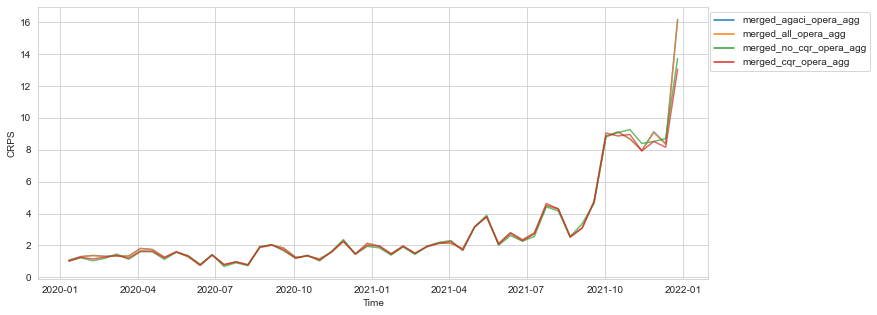

In [50]:
plt.figure(figsize=(12,5))
sns.lineplot(data=dfg.sort_values(by='Time').rename(columns ={'Models in' : 'Aggregated models', 'model_type' : 'Model type'}),
             x='Time',
             y='crps',
             hue='Model type',
             #style='Model type',
             #palette =dic_colors.values(),
            linewidth=1.5, alpha=0.7)
plt.legend(loc='upper right', bbox_to_anchor=(1.25,1))
plt.ylabel('CRPS')
plt.show()

## II.3 - Prediction intervals for a few hours

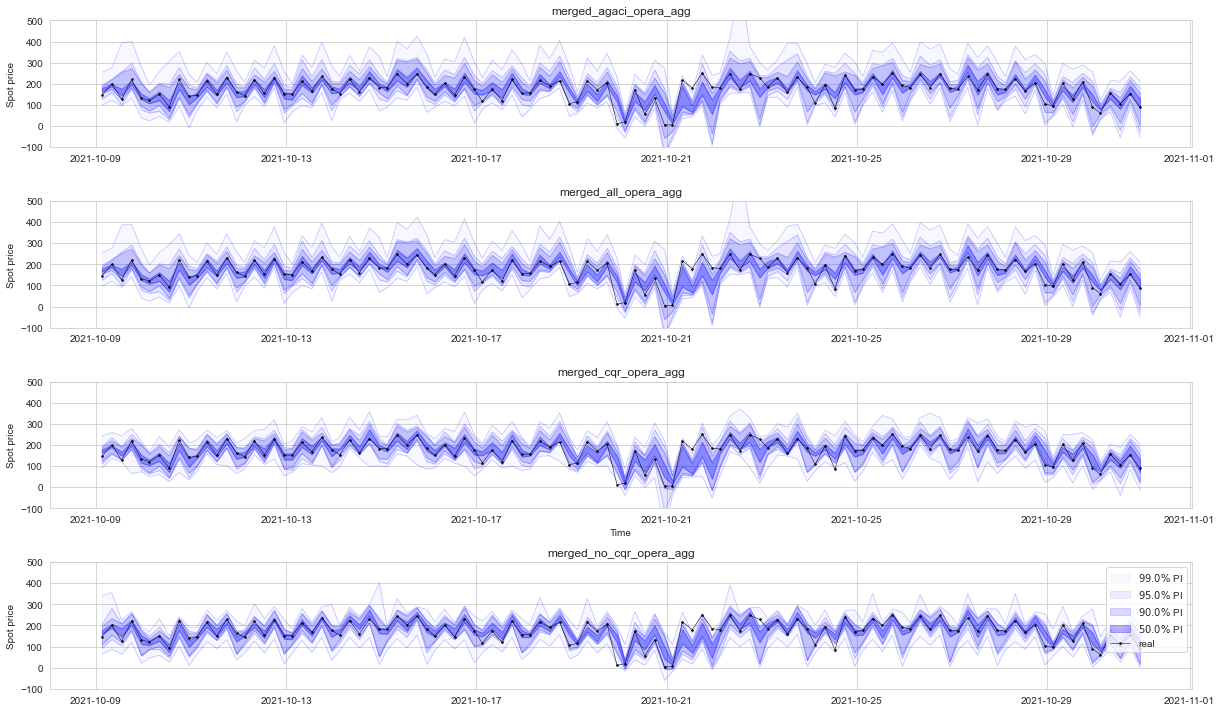

In [54]:
dates = ['2021-10-09', '2021-10-30']
fig, axes = plt.subplots(4)
transparency = [0.03, 0.075, 0.15, 0.3]


# Figure 1

for i, alpha in enumerate([0.99, 0.95, 0.9, 0.5]):
    q_low, q_up = np.round(100*(1- alpha)/2, 2), np.round(100*(1+alpha)/2, 2)
    df1 = df[(df.model == 'merged_agaci_opera_agg') 
             & (df['quantile'] == q_low)
             & (df.Date >= dates[0])
             & (df.Date <= dates[1])].sort_values(by='Time')

    df2 = df[(df.model == 'merged_agaci_opera_agg') 
             & (df['quantile'] == q_up)
             & (df.Date >= dates[0])
             & (df.Date <= dates[1])].sort_values(by='Time')

    axes[0].plot(df1.Time, df1.SpotPrice_pred, alpha=0.3, color='b', linewidth=0.5)
    axes[0].plot(df2.Time, df2.SpotPrice_pred, alpha=0.3, color='b', linewidth = 0.5)
    axes[0].fill_between(df1.Time, df1.SpotPrice_pred, df2.SpotPrice_pred, alpha=transparency[i], color='b', label = f'$ {100 * alpha} \%$ PI')
    axes[0].set_title('merged_agaci_opera_agg')
axes[0].plot(df1.Time, df1.SpotPrice, color='k', linewidth=0.5, marker='.', markersize=3, label = 'real')

# Figure 2

for i, alpha in enumerate([0.99, 0.95, 0.9, 0.5]):
    q_low, q_up = np.round(100*(1- alpha)/2, 2), np.round(100*(1+alpha)/2, 2)
    df1 = df[(df.model == 'merged_all_opera_agg') 
             & (df['quantile'] == q_low)
             & (df.Date >= dates[0])
             & (df.Date <= dates[1])].sort_values(by='Time')

    df2 = df[(df.model == 'merged_all_opera_agg') 
             & (df['quantile'] == q_up)
             & (df.Date >= dates[0])
             & (df.Date <= dates[1])].sort_values(by='Time')

    axes[1].plot(df1.Time, df1.SpotPrice_pred, alpha=0.3, color='b', linewidth=0.5)
    axes[1].plot(df2.Time, df2.SpotPrice_pred, alpha=0.3, color='b', linewidth = 0.5)
    axes[1].fill_between(df1.Time, df1.SpotPrice_pred, df2.SpotPrice_pred, alpha=transparency[i], color='b', label = f'$ {100 * alpha} \%$ PI')
    axes[1].set_title('merged_all_opera_agg')
axes[1].plot(df1.Time, df1.SpotPrice, color='k', linewidth=0.5, marker='.', markersize=3, label = 'real')

# Figure 3

for i, alpha in enumerate([0.99, 0.95, 0.9, 0.5]):
    q_low, q_up = np.round(100*(1- alpha)/2, 2), np.round(100*(1+alpha)/2, 2)
    df1 = df[(df.model == 'merged_cqr_opera_agg') 
             & (df['quantile'] == q_low)
             & (df.Date >= dates[0])
             & (df.Date <= dates[1])].sort_values(by='Time')

    df2 = df[(df.model == 'merged_cqr_opera_agg') 
             & (df['quantile'] == q_up)
             & (df.Date >= dates[0])
             & (df.Date <= dates[1])].sort_values(by='Time')

    axes[2].plot(df1.Time, df1.SpotPrice_pred, alpha=0.3, color='b', linewidth=0.5)
    axes[2].plot(df2.Time, df2.SpotPrice_pred, alpha=0.3, color='b', linewidth = 0.5)
    axes[2].fill_between(df1.Time, df1.SpotPrice_pred, df2.SpotPrice_pred, alpha=transparency[i], color='b', label = f'$ {100 * alpha} \%$ PI')
    axes[2].set_title('merged_cqr_opera_agg')
axes[2].plot(df1.Time, df1.SpotPrice, color='k', linewidth=0.5, marker='.', markersize=3, label = 'real')

# Figure 4

for i, alpha in enumerate([0.99, 0.95, 0.9, 0.5]):
    q_low, q_up = np.round(100*(1- alpha)/2, 2), np.round(100*(1+alpha)/2, 2)
    df1 = df[(df.model == 'merged_no_cqr_opera_agg') 
             & (df['quantile'] == q_low)
             & (df.Date >= dates[0])
             & (df.Date <= dates[1])].sort_values(by='Time')

    df2 = df[(df.model == 'merged_no_cqr_opera_agg') 
             & (df['quantile'] == q_up)
             & (df.Date >= dates[0])
             & (df.Date <= dates[1])].sort_values(by='Time')

    axes[3].plot(df1.Time, df1.SpotPrice_pred, alpha=0.3, color='b', linewidth=0.5)
    axes[3].plot(df2.Time, df2.SpotPrice_pred, alpha=0.3, color='b', linewidth = 0.5)
    axes[3].fill_between(df1.Time, df1.SpotPrice_pred, df2.SpotPrice_pred, alpha=transparency[i], color='b', label = f'$ {100 * alpha} \%$ PI')
    axes[3].set_title('merged_no_cqr_opera_agg')
axes[3].plot(df1.Time, df1.SpotPrice, color='k', linewidth=0.5, marker='.', markersize=3, label = 'real')



for i in range(4):
    axes[i].set_ylabel('Spot price')
    axes[i].set_ylim([-100, 500])
axes[2].set_xlabel('Time')

fig.set_size_inches((17, 10))
fig.tight_layout()

plt.legend()
plt.show()


## II.4 - Table of results


In [67]:
df_crps = pd.DataFrame()

for i, model in enumerate(df.model.unique()):
    for id_ in [0,1]:
        dfm = df[(df.model == model) & (df['After Sept 2021'] == id_)]
        dfp = pd.pivot_table(dfm,
                   values=['SpotPrice_pred'],
                   index = ["Date", 'Hour', 'model', 'model_type', 'SpotPrice'],
                   columns = ['quantile']
                  ).reset_index()

        y_true = dfp.SpotPrice.to_numpy()
        quantile_forecast = dfp.SpotPrice_pred.to_numpy()
        
        
        # Add the zero-th quantile
        tab_quantile = np.array([0] + list(dfp.SpotPrice_pred.columns))
        quantile_forecast = np.hstack([np.repeat(-500, len(y_true)).reshape(-1, 1),  quantile_forecast]).T

        df_temp = pd.DataFrame()
        df_temp['model'] = [model]
        df_temp['After Sept 2021'] = [id_]
        df_temp["model_type"] = [dfm.model_type.unique()[0]]
        df_temp["Models in"] = [dfm['Models in'].unique()[0]]
        
        
        # Kupiec test at 95 %
        hour_successes = []
        for hour in df.Hour.unique():
            dfq_low = dfm[(dfm['quantile'] == 2.5) & (dfm['Hour']==hour)]
            dfq_high = dfm[(dfm['quantile'] == 97.5) & (dfm['Hour']==hour)]
            hour_successes.append(kupiec_test(dfq_low.SpotPrice.to_numpy(),
                        dfq_low.SpotPrice_pred.to_numpy(),
                        dfq_high.SpotPrice_pred.to_numpy(), alpha=0.05, conf_level = 0.95)[1])
        df_temp['Kupiec Test (95 $\%$)'] = [np.sum(hour_successes)]

        # Kupiec test at 90 %
        hour_successes = []
        for hour in df.Hour.unique():
            dfq_low = dfm[(dfm['quantile'] == 5) & (dfm['Hour']==hour)]
            dfq_high = dfm[(dfm['quantile'] == 95) & (dfm['Hour']==hour)]
            hour_successes.append(kupiec_test(dfq_low.SpotPrice.to_numpy(),
                        dfq_low.SpotPrice_pred.to_numpy(),
                        dfq_high.SpotPrice_pred.to_numpy(), alpha=0.1, conf_level = 0.95)[1])
        df_temp['Kupiec Test (90 $\%$)'] = [np.sum(hour_successes)]

        # Kupiec test at 50 %
        hour_successes = []
        for hour in df.Hour.unique():
            dfq_low = dfm[(dfm['quantile'] == 25) & (dfm['Hour']==hour)]
            dfq_high = dfm[(dfm['quantile'] == 75) & (dfm['Hour']==hour)]
            hour_successes.append(kupiec_test(dfq_low.SpotPrice.to_numpy(),
                        dfq_low.SpotPrice_pred.to_numpy(),
                        dfq_high.SpotPrice_pred.to_numpy(), alpha=0.5, conf_level = 0.95)[1])
        df_temp['Kupiec Test (50 $\%$)'] = [np.sum(hour_successes)]
        
        # CRPS 
        df_temp['CRPS'] = [mean_crps(y_true, quantile_forecast, tab_quantile/100)]

        df_crps = df_crps.append(df_temp)

df_crps.columns = ['model', 'Period', 'model_type', "Models in", 'Kupiec Test (95 $\%$)',
       'Kupiec Test (90 $\%$)', 'Kupiec Test (50 $\%$)', 'CRPS']
df_crps.Period.replace({0 : 'Before Sept 2021', 1 : 'After Sept 2021'}, inplace=True)


# Show table
pd.pivot_table(np.round(df_crps, 2), values = ['CRPS',
                                  'Kupiec Test (95 $\%$)',
                                  'Kupiec Test (90 $\%$)',
                                  'Kupiec Test (50 $\%$)'],
              index = ['model_type'],#, 'Models in'],
              columns = ['Period'])

CRPS                   \
Period                  After Sept 2021 Before Sept 2021   
model_type                                                 
merged_agaci_opera_agg             8.79             1.91   
merged_all_opera_agg               8.76             1.90   
merged_cqr_opera_agg               8.48             1.89   
merged_no_cqr_opera_agg            8.69             1.86   

                        Kupiec Test (50 $\%$)                   \
Period                        After Sept 2021 Before Sept 2021   
model_type                                                       
merged_agaci_opera_agg                      5                4   
merged_all_opera_agg                        5                3   
merged_cqr_opera_agg                        5                3   
merged_no_cqr_opera_agg                     5                4   

                        Kupiec Test (90 $\%$)                   \
Period                        After Sept 2021 Before Sept 2021   
model_type                                                       
merged_agaci_opera_agg                      5                3   
merged_all_opera_agg                        5                3   
merged_cqr_opera_agg                        5                3   
merged_no_cqr_opera_agg                     0                3   

                        Kupiec Test (95 $\%$)                   
Period                        After Sept 2021 Before Sept 2021  
model_type                                                      
merged_agaci_opera_agg                      5                3  
merged_all_opera_agg                        5                1  
merged_cqr_opera_agg                        3                4  
merged_no_cqr_opera_agg                     0                4

In [64]:
# To latex
print(str(pd.pivot_table(np.round(df_crps, 2), values = ['CRPS',
                                  'Kupiec Test (95 $\%$)',
                                  'Kupiec Test (90 $\%$)',
                                  'Kupiec Test (50 $\%$)'],
              index = ['model_type', 'Models in'],
              columns = ['Period']).to_latex()).replace('         ', "").replace("  ", ""))

\begin{tabular}{llrrrrrrrr}
\toprule
& {} & \multicolumn{2}{l}{CRPS} & \multicolumn{2}{l}{Kupiec Test (50 \$\textbackslash \%\$)} & \multicolumn{2}{l}{Kupiec Test (90 \$\textbackslash \%\$)} & \multicolumn{2}{l}{Kupiec Test (95 \$\textbackslash \%\$)} \\
& Period & After Sept 2021 & Before Sept 2021 & After Sept 2021 & Before Sept 2021 & After Sept 2021 & Before Sept 2021 & After Sept 2021 & Before Sept 2021 \\
model\_type & Models in &&& && && &\\
\midrule
merged\_agaci\_opera\_agg & All & 8.79 &1.91 & 5 & 4 & 5 & 3 & 5 & 3 \\
merged\_all\_opera\_agg & All & 8.76 &1.90 & 5 & 3 & 5 & 3 & 5 & 1 \\
merged\_cqr\_opera\_agg & All & 8.48 &1.89 & 5 & 3 & 5 & 3 & 3 & 4 \\
merged\_no\_cqr\_opera\_agg & All & 8.69 &1.86 & 5 & 4 & 0 & 3 & 0 & 4 \\
\bottomrule
\end{tabular}

